### 一.算法流程
adaboost回归模型与分类模型类似，主要的不同点在于错误率的计算、基模型的权重计算以及样本权重的更新，下面就直接介绍算法流程部分

输入：训练集$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$，其中$x_i\in R^n,y_i\in R,i=1,2,...,N$   

输出：最终回归模型$G(x)$  

>（1）初始化训练数据的权重分布：  
$$
D_1=(w_{11},...,w_{1i},...,w_{1N}),w_{1i}=\frac{1}{N},i=1,2,...,N
$$  
>（2）对$m=1,2,...,M:$   
>>（2.1）使用具有权重分布$D_m$的训练数据集学习，得到基回归模型：$G_m(x)$   
>>（2.2）计算$G_m(x)$在训练集上的误差率：  
>>>(2.2.1)计算训练集上的最大误差：$E_m=max\mid y_i-G_m(x_i)\mid,i=1,2,...,N$  
>>>(2.2.2)计算每个样本的相对误差，这里有三种计算方式可选：  
>>>> a)线性误差：$e_{mi}=\frac{\mid y_i-G_m(x_i)\mid}{E_m},i=1,2,...,N$  
>>>> b)平方误差：$e_{mi}=\frac{(y_i-G_m(x_i))^2}{E_m^2},i=1,2,...,N$  
>>>> c)指数误差：$e_{mi}=1-exp(\frac{-\mid y_i-G_m(x_i)\mid}{E_m}),i=1,2,...,N$
>>>(2.2.3)计算误差率：$e_m=\sum_{i=1}^N w_{mi}e_{mi},i=1,2,...,N$
>>（2.3）计算$G_m(x)$的权重系数：$\alpha_m=\frac {e_m}{1-e_m}$  
>>（2.4）更新训练样本权重：  
$$
w_{m+1,i}=\frac{w_{mi}}{Z_m}\alpha_m^{1-e_{mi}},i=1,2,...,N
$$  
这里$Z_m$是归一化因子   
>（3）最终强学习器：  
$$
G(x)=\sum_{i=1}^M \frac {ln\frac{1}{\alpha_m}}{L}G_m(x),L=\sum_{i=1}^M ln\frac{1}{\alpha_m}
$$

### 二.代码实现

In [4]:
import os
os.chdir('../')
from ml_models.tree import CARTRegressor
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class AdaBoostRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = CARTRegressor(max_depth=2)
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)

        # 记录estimator权重
        self.estimator_weights = []

        # 记录最终中位数值弱学习器的index
        self.median_index = None

    def fit(self, x, y):
        n_sample = x.shape[0]
        sample_weights = np.asarray([1.0] * n_sample)
        for index in range(0, self.n_estimators):
            self.base_estimator[index].fit(x, y, sample_weight=sample_weights)

            errors = np.abs(self.base_estimator[index].predict(x) - y)
            error_max = np.max(errors)

            # 计算线性误差，其他误差类型，可以自行扩展
            linear_errors = errors / error_max
            # 计算误分率
            error_rate = np.dot(linear_errors, sample_weights / n_sample)

            # 计算权重系数
            alpha_rate = error_rate / (1.0 - error_rate + 1e-10)
            self.estimator_weights.append(alpha_rate)

            # 更新样本权重
            for j in range(0, n_sample):
                sample_weights[j] = sample_weights[j] * np.power(alpha_rate, 1 - linear_errors[j])
            sample_weights = sample_weights / np.sum(sample_weights) * n_sample

        # 更新estimator权重
        self.estimator_weights = np.log(1 / np.asarray(self.estimator_weights))
        for i in range(0, self.n_estimators):
            self.estimator_weights[i] *= np.power(self.learning_rate, i)
        self.estimator_weights /= np.sum(self.estimator_weights)

    def predict(self, x):
        return np.sum(
            [self.estimator_weights[i] * self.base_estimator[i].predict(x) for i in
             range(0, self.n_estimators)],
            axis=0)

.


In [2]:
#构造数据
data = np.linspace(1, 10, num=100)
target = np.sin(data) + np.random.random(size=100)#添加噪声
data = data.reshape((-1, 1))

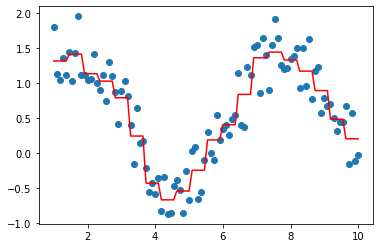

In [3]:
#训练模型
model=AdaBoostRegressor(base_estimator=CARTRegressor(max_bins=20),n_estimators=10)
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')